# Example Motion Prediction
In this example, we take a look at how to perform motion prediction in python in a Jupyter environment. We will walk you through the steps and hopefully, you will be able to modify this example. 

## 0.0 Importing 
In python you have to tell the script which modules you want to use. [Help](https://docs.python.org/3/reference/import.html) 
Each "module" consists of "functions" that can be used after importing the module. You can also `import` single functions `from` a module. For later use, you can assign a nickname to a module, like `numpy as np`. You will call `numpy` functions as `np.someFunction` then. 
Oh, by the way: This text you are reading right now is written in  [Markdown](https://en.wikipedia.org/wiki/Markdown) format. Which comes with a bunch of formatting features as you can see. This can help to communicate your thoughts in such a notebook.

### 0.1 Importing Modules
Since we are working in Jupyter, we can run the cell below with all the import commands independently of the code below that cell.
Click into the cell below and do one of the things below:
- `Shift + Enter` will run the cell and moves to the next cell.
- `Crtl + Enter` will run the cell but won't move to the next cell.
- Move your mouse to the play symbol above and click.

In [1]:
import os
import sys
import xlsxwriter
from sklearn import preprocessing
import numpy as np
import pandas as pd

print("Succesfully imported!!")

Succesfully imported!!


I also included a `print` command, so the notebook tells me right in place, that the cell is successfully evaluated, which is quite neat!

### 0.2 Adding Local Libraries
For this example, we've coded up some stuff to make our lifes (and maybe your's) easier. But since we didn't want to have all this arkward code hanging around in this nice little notebook, we crammed it into some regular python scripts, which can also be used in Jupyter. To take a look at this code, follow the path below:

In [2]:
sys.path.append('data_processing/')
from readDataset import dataGrabber
from preProcessing import preProcess
from dataPreparation import dataPrepare

## 1.0 Get the Dataset Path
To start working, we need some data. If you put the dataset to the right place, the following command will point to the dataset. 

In [3]:
dataset_path = '../dataset/data/'
print(dataset_path)

../dataset/data/


## 2.0 Reading Data 
***(Use either 2.1 or 2.2)***

Our helper function are able to read the dataset from the csv-files and introduce it into the Jupyter workspace. Please use **one of the following two options!**


### 2.1 Data reading with location ID
Taking a look into the dataset, it is organized in locations with several recordings. The following will load all recordings from one location.

In [4]:
"""
# Edit to some other number to load a different dataset
locations_sel = ['4']

# Initialize data Grabber Object
data_obj = dataGrabber(dataset_path)

data_obj.location_id = locations_sel
data_obj.read_csv_with_location()

track_data_raw = data_obj.get_tracks_data()
track_meta_data_raw = data_obj.get_tracksMeta_data()
"""

"\n# Edit to some other number to load a different dataset\nlocations_sel = ['4']\n\n# Initialize data Grabber Object\ndata_obj = dataGrabber(dataset_path)\n\ndata_obj.location_id = locations_sel\ndata_obj.read_csv_with_location()\n\ntrack_data_raw = data_obj.get_tracks_data()\ntrack_meta_data_raw = data_obj.get_tracksMeta_data()\n"

Now we created a `data_obj`, which is an "object". In python you can use the whole array of "object-oriented-programming" [(OOP)](https://en.wikipedia.org/wiki/Object-oriented_programming) concepts.

### 2.2 Data reading with recording ID
Alternatively, you can use the following cell to load several recordings by recording ID. The code below is "commented out", so if you run the cell the python interpreter doesn't read it as instructions, but as text (that usually should comment what the code does).
If you remove the `"""` above and below the code, you can "uncomment" it and use it as acutal code.

In [5]:
recording_id_sel = ['27']

# Initialize data Grabber Object
data_obj = dataGrabber(dataset_path)

data_obj.recording_id = recording_id_sel
data_obj.read_csv_with_recordingID()

track_data_raw = data_obj.get_tracks_data()
track_meta_data_raw = data_obj.get_tracksMeta_data()  

## 3.0 Preprocessing the Data
When working with data, it occurs that we get weird, noisy, unnecessary, large, unstructured ... chunks of excel sheets. From this starting point, it is our job to make use of this data and turn it into information.
In our case, the dataset is at least in a given order, but we need to bring it into a nice structure to work with it. Therefore we create a `pre_process_obj` and hand it the data to extract some info first. 

In [6]:
pre_process_obj = preProcess()
pre_process_obj.tracks_data = track_data_raw
pre_process_obj.tracks_meta_data = track_meta_data_raw
pre_process_obj.recording_ids = data_obj.recording_id
pre_process_obj.data_len = len(track_data_raw)

### 3.1 Downsampling Data

Take look at the recording files and how many MB they consume on your hard drive. Now check how much RAM your machine has. To juggle all this data constantly on your RAM might be impossible for your machine (most likely) or it is possible and you should overthink your priorities in life.
Nonetheless, you don't need all your data to make nice prediction! More often than not, it is totally sufficient to use every $k$-th piece of data. The important thing to keep in mind is that you shouldn't make important **information** or **characteristics** of your data disappear. How do you know when this happens? You don't. At least you do not know for general data. For a specific subclass there exists the famous [Nyquist–Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem). Maybe you can lend some intuition of that idea to get the picture right.

See how many pieces of data you should skip to fit the requirements. Besides that, play around with the volume of data:
- What's the minimum frame rate you can get away with to make a nice prediction?
- What's the maximum frame rate your PC can handle?

In [7]:
# Define the number of frames to be skipped + 1 => here 4 frames are skipped so 4+1 = 5

pre_process_obj.frames_skipped = 5
track_data_downsampled, tracks_meta_data = pre_process_obj.get_down_sampled_data()
pre_process_obj.tracks_data = track_data_downsampled

In [8]:
pd.unique(track_data_downsampled["frame"])

array([    0,     5,    10, ..., 33195, 33200, 33205], dtype=int64)

In [9]:
# Set 'True' or 'False'  ->> Avoids unnecessary data preparation while physics based predition
PHYSICS_BASED_PREDICTION = False 
DATA_DRIVEN_PREDICTION = True

### 3.2 For Physical Model Based Prediction
No more cleaning is required because our specific dataset already looks kind of clean. At least in our view and for this example. Maybe you are up to something that requires additional steps. 

Some things you could encounter in data are
1. Missing data: Some track could be lost for some time and could be found again. How do you treat this gap? Did the dataset assign a new track ID although it is the same physical vehicle? 
2. Numeric issues: Everybody who uses google maps knows that teleportation is a thing. When you measure stuff, you can get weird outliers (huge or very small numbers) or for some reason they can get so huge that your PC cannot assign a numeric value anymore and therefore calls it NaN ("Not a Number"). "NaN"s are troublesome to handle because they are no numbers unlike all the regular, benign, well-behaved numbers in your data series. Some functions you want to use simply don't except NaNs and throw an error.


In [10]:
if PHYSICS_BASED_PREDICTION:
    track_data_downsamp_phy_model = track_data_downsampled 
    track_meta_data_phy_model = tracks_meta_data
### So maybe you want to jump directly to section 5

### 3.3 For Data-Driven Prediction Models

The following steps are specific to data-driven prediction models.

### 3.3.1 Label Encoding
Since the dataset contains alphabetical datatypes we need to cast them into numerical datatypes, since we want to process it mathematically. A common way to achieve this, is to "encode" "classes" as "integer" values.

In [11]:
if DATA_DRIVEN_PREDICTION:
    pre_process_obj.label_encoding()
    pre_process_obj.print_label_encoder_classes()

Labels Encoded
0 : bicycle
1 : car
2 : pedestrian
3 : truck_bus


### 3.3.2 Normalizing data between 0 and 1
To understand this step, I want you to refer to my youtube channel, where we've put together a nice playlist, with some background information about machine learning, motion prediction, python, jupyter notebooks and all that good stuff. Watch the linked video first!

Smash that like-button, subscribe and ring the bell and so on...!

[![](pictures_main/scalingYouTube.png)](https://www.youtube.com/watch?v=Y7m9MyPxcyQ&list=PLZ6Q6guexAFO_gbbxjxrNVrFx0zgIbmyN&index=24)

## "min_max_scalar_list" order:

```
Useful for inverse transform
        0: 'xCenter',   1: 'yCenter',       2: 'heading',       3: 'width',       4: 'length', 5: 'xVelocity',
        6: 'yVelocity', 7: 'xAcceleration', 8: 'yAcceleration', 9: 'lonVelocity', 10: 'latVelocity', 
       11:'lonAcceleration',  
       12:'latAcceleration'
           To USE: min_max_scalar_list[0] .... etc 
```

In [12]:
 if DATA_DRIVEN_PREDICTION:
    # Gets the tracks data normalized
    tracks_data_norm, min_max_scalar_list = pre_process_obj.normalize_data()

## 4.0 Preparing Data for Training and Testing
Our prediction function should receive some chunks of data from the past $x$ and should predict the output $y$. From the dataset, we know which $y$ should be predicted based on each $x$. So at time step $t_i$ we need to know our current data point $x_i$ (could be position or velocity or whatever) and some history of data points $x_{i-1} \dots x_{i-N_{past}}\,$  from the time steps before. ![](pictures_main/slidingWindow.png)
*Fig: Sliding Window on a time series*

When training a neural network, we want to approximate a function $f( \,)$ that maps our inputs $x$ to our outputs $y$
$$\large{y} = \large{f} \big(
        \begin{bmatrix}
            \mathbf{x_1}^T  & 
            \mathbf{x_2}^T & 
            \mathbf{\dots} &
            \mathbf{x_n}^T &
        \end{bmatrix}
    \big)$$
    
[![](pictures_main/NeuralNetworkYouTube.png)](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZ6Q6guexAFO_gbbxjxrNVrFx0zgIbmyN&index=2)
    
Therefore, we first need to know how our predictions $y$ should look like, so our training process is able to know how well the desired function is approximated. So in this case, we also have to grab the future values $x_{i+1} \dots x_{i+N_{future}}\,$ to declare them as output values $y_{i+1} \dots y_{i+N_{future}}\,$.
![](pictures_main/slidingWindow_Y.png)
*Fig: Sliding Window with inputs and outputs with $N_{past}$ = 3, $N_{future}$ = 2*

We need to do that anyway, because in the end, we need to evaluate how well we did with our prediction and therefore we will predict $\hat{y}_{i+1} \dots \hat{y}_{i+N_{future}}\,$ and need to compare this with the actual $y_{i+1} \dots y_{i+N_{future}}\,$.

### 4.1 Loading Data
First, we hand all the necessary data about the data to the object.

In [13]:
if DATA_DRIVEN_PREDICTION:
    # Resetting dropped frames index
    tracks_data_norm = tracks_data_norm.reset_index(drop=True)
    
    data_prepare_obj = dataPrepare()
    data_prepare_obj.tracks_data_norm = tracks_data_norm
    data_prepare_obj.tracksMeta_data = tracks_meta_data
    data_prepare_obj.data_len = len(tracks_data_norm)

### 4.2 Splitting Data

With its function `data_stacking()` the `data_prepare_obj` grabs the vectors from our time series in this sliding window fashion. Additionally, it stacks all the obtained sequences underneath each other in a single vector. Also additionally, it splits the final huge vector into a set of "training" data and "validation" data.

In [14]:
if DATA_DRIVEN_PREDICTION:
    # Number for track id to be used
    data_prepare_obj.track_id_range = 100
    
    data_prepare_obj.data_input = "normalized_data"
    xTrain_data, xTest_data, yTrain_data, yTest_data = data_prepare_obj.get_test_train_split()

This might take a while!
Current progress: 0.0 %
Current progress: 1.01 %
Current progress: 2.02 %
Current progress: 3.03 %
Current progress: 4.04 %
Current progress: 5.05 %
Current progress: 6.06 %
Current progress: 7.07 %
Current progress: 8.08 %
Current progress: 9.09 %
Current progress: 10.1 %
Current progress: 11.11 %
Current progress: 12.12 %
Current progress: 13.13 %
Current progress: 14.14 %
Current progress: 15.15 %
Current progress: 16.16 %
Current progress: 17.17 %
Current progress: 18.18 %
Current progress: 19.19 %
Current progress: 20.2 %
Current progress: 21.21 %
Current progress: 22.22 %
Current progress: 23.23 %
Current progress: 24.24 %
Current progress: 25.25 %
Current progress: 26.26 %
Current progress: 27.27 %
Current progress: 28.28 %
Current progress: 29.29 %
Current progress: 30.3 %
Current progress: 31.31 %
Current progress: 32.32 %
Current progress: 33.33 %
Current progress: 34.34 %
Current progress: 35.35 %
Current progress: 36.36 %
Current progress: 37.37 %
C

This concept of splitting the data into different parts is very important with regard to "overfitting". To get a bit of visual intuition, enjoy another video:
[![](pictures_main/splitDataYouTube.png)](https://www.youtube.com/watch?v=77jUW9IoooM&list=PLZ6Q6guexAFO_gbbxjxrNVrFx0zgIbmyN&index=27&t=868s)

### 4.3  Save Train, Test, Scalars in Pickle Files
Here we use pickle library to save and load test data

In [15]:
SAVE_PICKLE_FLAG = False
OPEN_PICKLE_FLAG = False
if DATA_DRIVEN_PREDICTION and SAVE_PICKLE_FLAG:
    # Save the xTrain, xTest, yTrain, xTest in pickle format
    data_prepare_obj.save_test_train_data_pickle()
if DATA_DRIVEN_PREDICTION and OPEN_PICKLE_FLAG:
    # Load the xTrain, xTest, yTrain, xTest from a pickle format
    data_prepare_obj.load_test_train_data_pickle()

## 5.0 Prediction Models

In this section you can introduce prepared predictions models from the folder `/prediction_models`. Prepare your own model there and load it into this file.

### 5.1 Constant Velocity Model
Take a look into the python file to see what is going on there!

In [16]:
sys.path.append('prediction_models/constant_velocity/')
from const_vel import my_constant_vel_model

### 5.2 Constant Acceleration Model

In [17]:
sys.path.append('prediction_models/constant_acceleration/')
from const_acc import my_constant_acc_model

### 5.3 Neural Network Models
Take a look into the python file to see what is going on there!

In [18]:
sys.path.append('prediction_models/neural_networks/')
from fcn_keras_model import FCN_keras_model

Epoch 1/100
3546/3546 [==============================] - 18s 5ms/step - loss: 0.0022 - val_loss: 4.0103e-04
Epoch 2/100
3546/3546 [==============================] - 16s 5ms/step - loss: 3.8093e-04 - val_loss: 3.8347e-04
Epoch 3/100
3546/3546 [==============================] - 15s 4ms/step - loss: 3.3762e-04 - val_loss: 2.6432e-04
Epoch 4/100
3546/3546 [==============================] - 17s 5ms/step - loss: 3.0323e-04 - val_loss: 2.5648e-04
Epoch 5/100
3546/3546 [==============================] - 14s 4ms/step - loss: 2.8384e-04 - val_loss: 4.7243e-04
Epoch 6/100
3546/3546 [==============================] - 16s 5ms/step - loss: 2.6416e-04 - val_loss: 2.1914e-04
Epoch 7/100
3546/3546 [==============================] - 14s 4ms/step - loss: 2.5499e-04 - val_loss: 2.1105e-04
Epoch 8/100
3546/3546 [==============================] - 17s 5ms/step - loss: 2.4813e-04 - val_loss: 2.0373e-04
Epoch 9/100
3546/3546 [==============================] - 16s 4ms/step - loss: 2.3995e-04 - val_loss: 2.2777e

3546/3546 [==============================] - 16s 4ms/step - loss: 1.3037e-04 - val_loss: 2.1276e-04
Epoch 74/100
3546/3546 [==============================] - 16s 5ms/step - loss: 1.3328e-04 - val_loss: 1.5680e-04
Epoch 75/100
3546/3546 [==============================] - 18s 5ms/step - loss: 1.2610e-04 - val_loss: 1.2862e-04
Epoch 76/100
3546/3546 [==============================] - 15s 4ms/step - loss: 1.3027e-04 - val_loss: 1.2683e-04
Epoch 77/100
3546/3546 [==============================] - 16s 4ms/step - loss: 1.2784e-04 - val_loss: 1.4139e-04
Epoch 78/100
3546/3546 [==============================] - 17s 5ms/step - loss: 1.2242e-04 - val_loss: 1.0486e-04
Epoch 79/100
3546/3546 [==============================] - 18s 5ms/step - loss: 1.2882e-04 - val_loss: 1.8355e-04
Epoch 80/100
3546/3546 [==============================] - 18s 5ms/step - loss: 1.2611e-04 - val_loss: 1.4097e-04
Epoch 81/100
3546/3546 [==============================] - 14s 4ms/step - loss: 1.2074e-04 - val_loss: 1.1075e

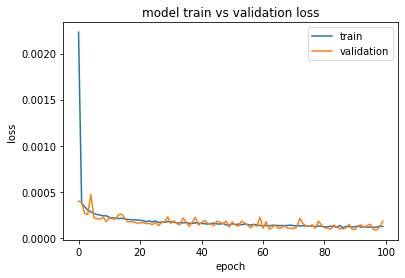

In [19]:
if DATA_DRIVEN_PREDICTION:
    FCN_model =  FCN_keras_model(xTrain_data, xTest_data, yTrain_data, yTest_data)

# 6.0 Prediction Testing
To see how well we did we need to use our model to make predictions. At the end of this section we want to write the data into an excel sheet. This excel sheet is needed to evaluate your predictions in a standardized fashion (important for the competition).
Now we need to generate predictions and compare it to the ground truth - what actually happened.

## 6.1 Generate Testset Data
First we produce some predictions.

## 6.1.1 For Physics Based Prediction

In [20]:
if PHYSICS_BASED_PREDICTION:
    recording_id_sel = ['28']
    data_sel_id = 0 # If there are multiple recordings added
    
    # Initialize data Grabber Object
    test_data_obj = dataGrabber(dataset_path)

    test_data_obj.recording_id = recording_id_sel
    test_data_obj.read_csv_with_recordingID()

    test_track_data = test_data_obj.get_tracks_data()
    test_track_meta_data = test_data_obj.get_tracksMeta_data() 


### Downsampling Data to Match Training Dataset

In [21]:
if PHYSICS_BASED_PREDICTION:
    test_pre_process_obj = preProcess()
    test_pre_process_obj.tracks_data = test_track_data
    test_pre_process_obj.tracks_meta_data = test_track_meta_data
    test_pre_process_obj.recording_ids = test_data_obj.recording_id
    test_pre_process_obj.data_len = len(test_track_data)
    
    test_pre_process_obj.frames_skipped = 5
    new_sampling_rate = 0.2
    test_pre_process_obj.new_sampling_rate = new_sampling_rate
    test_track_data_downsampled, test_tracks_meta_data = test_pre_process_obj.get_down_sampled_data()
    #test_pre_process_obj.tracks_data = test_track_data_downsampled

### Concatinating Dataframes and Sorting by "frame"

In [22]:
if PHYSICS_BASED_PREDICTION:
    sel_id = 0 # if multiple recording ids are selected -> index value of the array has to be given
        
    test_track_data_sel = track_data_downsampled
    test_track_meta_data_sel = test_track_meta_data

    # Reorder Tracks File by "frame"
    test_track_data_sel = test_track_data_sel.sort_values(["frame"], axis = 0, ascending = True)

## 6.1.2 For Data Driven Prediction

In [23]:
if DATA_DRIVEN_PREDICTION:   
    recording_id_sel = ['28']
    data_sel_id = 0 # If there are multiple recordings added
    
    # Initialize data Grabber Object
    test_data_obj = dataGrabber(dataset_path)

    test_data_obj.recording_id = recording_id_sel
    test_data_obj.read_csv_with_recordingID()

    test_track_data = test_data_obj.get_tracks_data()
    test_track_meta_data = test_data_obj.get_tracksMeta_data()    

### Preprocessing and Downsampling Data to Match Training Dataset

In [24]:
if DATA_DRIVEN_PREDICTION:   
    test_pre_process_obj = preProcess()
    test_pre_process_obj.tracks_data = test_track_data
    test_pre_process_obj.tracks_meta_data = test_track_meta_data
    test_pre_process_obj.recording_ids = test_data_obj.recording_id
    test_pre_process_obj.data_len = len(test_track_data)
    
    test_pre_process_obj.frames_skipped = 5
    test_track_data_downsampled, test_tracks_meta_data = test_pre_process_obj.get_down_sampled_data()
    test_pre_process_obj.tracks_data = test_track_data_downsampled

### Data Normalization

In [25]:
if DATA_DRIVEN_PREDICTION:   
    # Gets the tracks data normalized
    test_tracks_data_norm, min_max_scalar_list = test_pre_process_obj.normalize_data()
     # Resetting dropped frames index
    test_tracks_data_norm = test_tracks_data_norm.reset_index(drop=True)
    
    # Saving Normalized Data
    test_data_prepare_obj = dataPrepare()
    test_data_prepare_obj.tracks_data_norm = test_tracks_data_norm
    test_data_prepare_obj.tracksMeta_data = test_tracks_meta_data
    test_data_prepare_obj.data_len = len(test_tracks_data_norm)

### Data Stacking

In [26]:
if DATA_DRIVEN_PREDICTION:
    # Number for track id to be used
    test_data_prepare_obj.track_id_range = 10  
    
    # Gets the tracks data normalized and its ID
    test_data_prepare_obj.data_input = "normalized_data"
    t_norm_Ids, t_in_norm, t_out_norm = test_data_prepare_obj.data_stacking()
    # Predict the output
    n_input = np.shape(t_in_norm)[1] * np.shape(t_in_norm)[2]
    t_in_norm_reshaped = np.reshape(t_in_norm, (np.shape(t_in_norm)[0], n_input))

This might take a while!
Current progress: 0.0 %
Current progress: 11.11 %
Current progress: 22.22 %
Current progress: 33.33 %
Current progress: 44.44 %
Current progress: 55.56 %
Current progress: 66.67 %
Current progress: 77.78 %
Current progress: 88.89 %
Current progress: 100.0 %
Done! 


## 6.2 Collect Ground Truth

### 6.2.1 For Physics Based Modeling

In [27]:
sys.path.append('evaluation/')
from physics_based_pred_evaluator import physicsBasedEvaluation

In [28]:
if PHYSICS_BASED_PREDICTION: 
    phy_eval_obj = physicsBasedEvaluation()
    
    phy_eval_obj.selected_data = test_track_data_sel

     # Setting Other Parameters        
    phy_eval_obj.max_num_frames = int(test_track_data_sel.max()["frame"])
    phy_eval_obj.recording_id = recording_id_sel[sel_id]
    
    phy_eval_obj.pred_horizon = 15
    phy_eval_obj.frame_range = 100
    
    # Should be same as what used during downsampling => 5
    phy_eval_obj.frames_skipped = pre_process_obj.frames_skipped 
    
    track_data_sampled = list()
    test_track_data_sel = test_track_data_sel.sort_values(["frame", "trackId"], axis = 0, ascending = True)

Get Ground Truth

In [29]:
if PHYSICS_BASED_PREDICTION:
    ground_truth, track_id_counter = phy_eval_obj.get_ground_truth()

Get Predicted Value

In [30]:
if PHYSICS_BASED_PREDICTION:
    const_vel_model_prediction = my_constant_vel_model(test_track_data_sel, phy_eval_obj.pred_horizon, new_sampling_rate, phy_eval_obj.frame_range)

Storing Predicted Values and Ground Truth into the Evaluation

In [31]:
if PHYSICS_BASED_PREDICTION:
    phy_eval_obj.predicted_data = const_vel_model_prediction
    phy_eval_obj.ground_truth_data = ground_truth

Create Evaluation Workbook and Add Data

In [32]:
if PHYSICS_BASED_PREDICTION:
    work_book_filename = 'constant_velocity_prediction_result.xlsx' 
elif DATA_DRIVEN_PREDICTION:
    work_book_filename = 'NN_velocity_prediction_result_2.xlsx' 

Delete the File if Exists

In [33]:
if PHYSICS_BASED_PREDICTION:
    if os.path.exists(work_book_filename):
        os.remove(work_book_filename)

Write To Workbook

In [34]:
if PHYSICS_BASED_PREDICTION:
    phy_eval_obj.wb_filename = work_book_filename
    phy_eval_obj.write_to_workbook()

### 6.2.2 For Data-Driven Prediction Models

In [35]:
sys.path.append('evaluation/')
from data_driven_pred_evaluator import dataDrivenEvaluation

In [36]:
if DATA_DRIVEN_PREDICTION: 
    data_eval_obj = dataDrivenEvaluation()    

Get Ground Truth Data Preparation

In [37]:
if DATA_DRIVEN_PREDICTION:
    # Resetting dropped frames index
    test_track_data_downsampled = test_track_data_downsampled.reset_index(drop=True)
    ground_truth_prepare_obj = dataPrepare()
    ground_truth_prepare_obj.data_input = "raw_data"
    ground_truth_prepare_obj.track_id_range = 10
    ground_truth_prepare_obj.tracksMeta_data = test_tracks_meta_data
    ground_truth_prepare_obj.tracks_data_norm = test_tracks_data_norm
    ground_truth_prepare_obj.tracks_data = test_track_data_downsampled
    ground_truth_prepare_obj.data_len = len(test_track_data_downsampled) 
    #ground_truth_prepare_obj.num_predict = 15
    t_raw_Ids, t_in_raw, t_out_raw = ground_truth_prepare_obj.data_stacking()

This might take a while!
Current progress: 0.0 %
Current progress: 11.11 %
Current progress: 22.22 %
Current progress: 33.33 %
Current progress: 44.44 %
Current progress: 55.56 %
Current progress: 66.67 %
Current progress: 77.78 %
Current progress: 88.89 %
Current progress: 100.0 %
Done! 


Copy ground truth data to data driven evaluator

In [38]:
if DATA_DRIVEN_PREDICTION:
    data_eval_obj.t_raw_Ids = t_raw_Ids
    data_eval_obj.t_in_raw = t_in_raw
    data_eval_obj.t_out_raw = t_out_raw

Get Ground Truth

In [39]:
if DATA_DRIVEN_PREDICTION:
    xCenter_gt, yCenter_gt, heading_gt = data_eval_obj.get_ground_truth()

Get Predicted Value

Use Predict Function for the Model Created

In [40]:
if DATA_DRIVEN_PREDICTION:
    yhat = FCN_model.predict(t_in_norm_reshaped, verbose=0)
    
    # Save Predicted Data into the Evaluator
    data_eval_obj.y_hat = yhat

In [41]:
if DATA_DRIVEN_PREDICTION:
    # Set Paramters
    data_eval_obj.min_max_scalar_list = min_max_scalar_list
    
    # Get Prediction
    xCenter_prediction, yCenter_prediction, heading_prediction = data_eval_obj.get_prediction()

Delete the File if Exists

In [42]:
if DATA_DRIVEN_PREDICTION:
    if os.path.exists(work_book_filename):
        os.remove(work_book_filename)

Write To Workbook (Excel-Sheet)

In [43]:
if DATA_DRIVEN_PREDICTION:
    data_eval_obj.wb_filename = work_book_filename
    data_eval_obj.write_to_workbook()

## 7.0 Evaluation
Now it's the moment of truth!! We load the data now from the excel sheet and calculate three error metrics:
1. **Average Displacement Error (ADE):** 
Average Displacement Error (ADE): ADE refers to the mean square error (MSE) over all estimated points of every trajectory and the true points.
$$
\text{ADE} = \frac
{\sum_{i=1}^{n}\sum_{t=T_{Frame}}^{T_{pred}} \quad  \big[(\hat{x}_i^t - x_i^t)^2 + (\hat{y}_i^t - y_i^t)^2 \big]}
{n(T_{pred}-(T_{Frame}+1))}
$$

2. **Final displacement error (FDE):** 
FDE means the distance between the predicted final destination and the true final destination at the $T_{pred}$ time.
$$
\text{FDE} = \frac
{\sum_{i=1}^n \sqrt{\big( \, \hat{x}_i^{T_{pred}} - x_i^{T_{pred}} \, \,\big)^2  + \big( \, \hat{y}_i^{T_{pred}} - y_i^{T_{pred}} \, \,\big)^2 }}
{n}
$$ 

3. **Average Absolute Heading Error (AHE):** 
This is a bit like ADE but we take the 1-norm of the error and we only consider the heading prediction here.
$$
\text{AHE} = \frac
{\sum_{i=1}^{n}\sum_{t=T_{Frame}}^{T_{pred}} \quad \big| \hat{y}_i^t - y_i^t \big| }
{n(T_{pred}-(T_{Frame}+1))}
$$

In [44]:
from evaluation_matrix import evaluationMatrix

In [45]:
if PHYSICS_BASED_PREDICTION:
    eval_obj = evaluationMatrix(work_book_filename, phy_eval_obj.pred_horizon)  
elif DATA_DRIVEN_PREDICTION:
    eval_obj = evaluationMatrix(work_book_filename, data_eval_obj.n_predict) 

In [46]:
ade_value, fde_value, ahe_val = eval_obj.get_fde_ade_ahe()

The average displacement error is 3.403 m
The average final displacement error is 3.681 m
The average absolute heading error is 5.83 degrees
